In [2]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.metrics import pairwise_distances
import seaborn as sns


# Import des données 

In [3]:
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

In [4]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" ))
rois_train["set"] = 'train'
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" ))
rois_test["set"] = 'test'
rois = pd.concat([rois_train, rois_test])

In [5]:
test_vbm = np.load("data/test_vbm.npz",  allow_pickle=True)
train_vbm = np.load("data/train_vbm.npz",  allow_pickle=True)

In [6]:
labels_path = "AAL3v1.nii.txt"  
labels = {}

with open(labels_path, "r") as f:
    for line in f:
        idx, name = line.strip().split(maxsplit=1)
        labels[int(idx)] = name


In [8]:

img = nib.load('ROI_MNI_V7.nii')  
data = img.get_fdata()


NameError: name 'nib' is not defined

# Exploration

## Imagerie préléminaire

Enseignements: 
Les dimensions spatiales de l'image (121 x 145 x 121) indiquent qu'il y a 121 coupes dans la direction axiale (de haut en bas du cerveau).


In [10]:
train_vbm.files

['imgs_arr', 'mask_arr', 'affine', 'participant_id']

In [ ]:
imgs_arr = train_vbm['imgs_arr'] #mages volumétriques ou des données IRM
print(imgs_arr[0, 0])
#[index participant,  dimension pour le canal, dimensions 1 spatiales en voxels,dimensions 2 spatiales en voxels, dimensions 1 spatiales en voxels ]

In [ ]:
# masques pour sélectionner ou isoler la région d'intérêt (ROI, Region of Interest) 
# Des valeurs booléens (0 ou 1) indiquant si un voxel fait partie ou non de la région ciblée.
mask_arr = train_vbm['mask_arr'] 
print(mask_arr[40:50])

In [ ]:
affine = train_vbm['affine'] #mages volumétriques ou des données IRM
print(affine)

In [ ]:
for idx in range(0, 121, 10):  # Parcourir toutes les 10 coupes
    plt.imshow(imgs_arr[0, 0][:, :, idx] * mask_arr[:, :, idx], cmap='gray', origin='lower')
    plt.title(f"Coupe {idx} ")
    plt.show()


In [ ]:
# Visualiser une coupe (slice) axiale du premier volume
volume = imgs_arr[0, 0]
slice_axial = volume[:, :, 60]  # 60ème coupe
plt.imshow(slice_axial.T, cmap='gray', origin='lower')
plt.title("Coupe axiale du cerveau (participant 01)")
plt.show()
#présenter la transformation spatiale entre l'espace des voxels (coordonnées de l'image) et un espace de référence standard

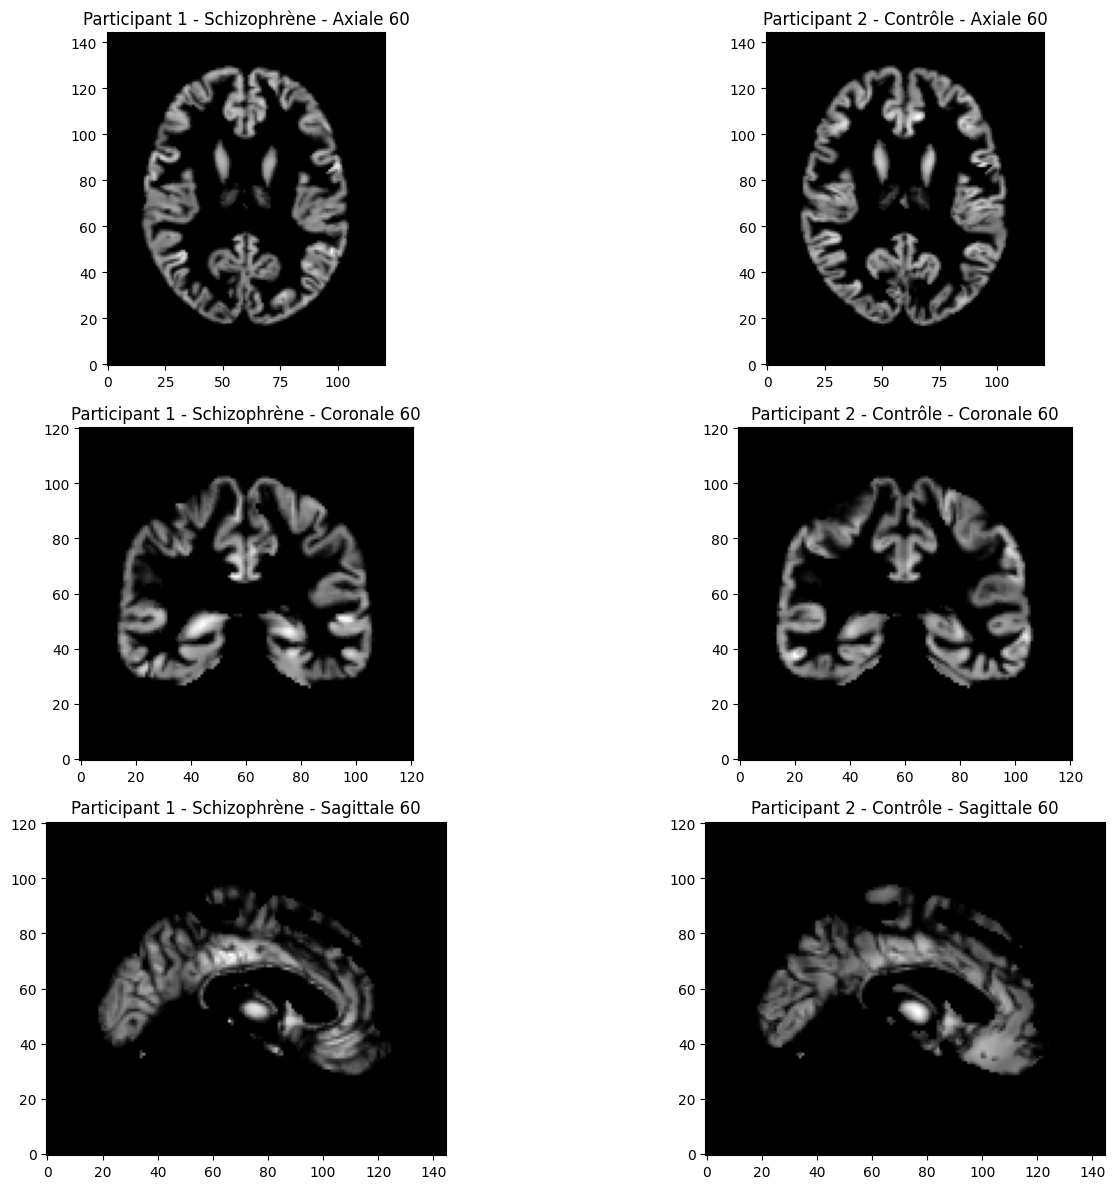

In [18]:

imgs_arr = train_vbm['imgs_arr']
mask_arr = train_vbm['mask_arr']
participant_id = train_vbm['participant_id']

participant_1 = imgs_arr[100, 0]  # Volume 3D du participant 1 (schizophrène)
participant_2 = imgs_arr[2, 0]  # Volume 3D du participant 2 (contrôle)

# Masquer les données
masked_1 = participant_1[mask_arr]
masked_2 = participant_2[mask_arr]

# Index de coupe (vous pouvez en afficher plusieurs)
slice_idx = 60

# Extraire des coupes (axiale, coronale et sagittale)
masked_slice_axial_1 = participant_1[:, :, slice_idx] * mask_arr[:, :, slice_idx]
masked_slice_axial_2 = participant_2[:, :, slice_idx] * mask_arr[:, :, slice_idx]

masked_slice_coronal_1 = participant_1[:, slice_idx, :] * mask_arr[:, slice_idx, :]
masked_slice_coronal_2 = participant_2[:, slice_idx, :] * mask_arr[:, slice_idx, :]

masked_slice_sagittal_1 = participant_1[slice_idx, :, :] * mask_arr[slice_idx, :, :]
masked_slice_sagittal_2 = participant_2[slice_idx, :, :] * mask_arr[slice_idx, :, :]

# Tracer les graphiques
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Axiale
axes[0, 0].imshow(masked_slice_axial_1.T, cmap='gray', origin='lower')
axes[0, 0].set_title(f"Participant 1 - Schizophrène - Axiale {slice_idx}")
axes[0, 1].imshow(masked_slice_axial_2.T, cmap='gray', origin='lower')
axes[0, 1].set_title(f"Participant 2 - Contrôle - Axiale {slice_idx}")

# Coronale
axes[1, 0].imshow(masked_slice_coronal_1.T, cmap='gray', origin='lower')
axes[1, 0].set_title(f"Participant 1 - Schizophrène - Coronale {slice_idx}")
axes[1, 1].imshow(masked_slice_coronal_2.T, cmap='gray', origin='lower')
axes[1, 1].set_title(f"Participant 2 - Contrôle - Coronale {slice_idx}")

# Sagittale
axes[2, 0].imshow(masked_slice_sagittal_1.T, cmap='gray', origin='lower')
axes[2, 0].set_title(f"Participant 1 - Schizophrène - Sagittale {slice_idx}")
axes[2, 1].imshow(masked_slice_sagittal_2.T, cmap='gray', origin='lower')
axes[2, 1].set_title(f"Participant 2 - Contrôle - Sagittale {slice_idx}")

plt.tight_layout()
plt.show()

## Atlas

In [26]:
# Extraire les indices des schizophrènes et des contrôles
schizophrenia_indices = participants.index[participants['diagnosis'] == 'schizophrenia'].tolist()
control_indices = participants.index[participants['diagnosis'] == 'control'].tolist()


In [26]:
print("Labels des régions AAL :")
for i in range(1, 6):
    print(f"{i}: {labels[i]}")


Labels des régions AAL :
1: Precentral_L 1
2: Precentral_R 2
3: Frontal_Sup_2_L 3
4: Frontal_Sup_2_R 4
5: Frontal_Mid_2_L 5


In [61]:
# Correspondance entre les régions d'intérêt et les labels AAL
regions_of_interest = {
    "CSF_Vol": ["CSF"],  # Ventricules latéraux gauche et droit
    "lMidFroGy_GM_Vol": ["Frontal_Mid_2_L"],  # Gyrus frontal moyen gauche
    "lTemPo_CSF_Vol": ["Temporal_Pole_Sup_L"],  # Pôle temporal supérieur gauche
    "rTemPo_CSF_Vol": ["Temporal_Pole_Sup_R"],  # Pôle temporal supérieur droit
    "rThaPro_GM_Vol": ["Thalamus_R"],  # Thalamus droit
    "rLinGy_CSF_Vol": ["Lingual_R"],  # Gyrus lingual droit
    "rLatVen_CSF_Vol": ["Lateral_Ventricle_R"],  # Ventricule latéral droit
}



In [64]:
label_to_index = {name: idx for idx, name in labels.items()}

regions_of_interest_indices = {
    key: [label_to_index[region] for region in regions if region in label_to_index]
    for key, regions in regions_of_interest.items()
}
# Préparer une table de correspondances avec toutes les régions d'intérêt et leurs indices
region_table_data = []

for roi, indices in regions_of_interest_indices.items():
    for index in indices:
        region_table_data.append({
            "Region of Interest": roi,
            "AAL Label": labels[index],
            "AAL Index": index
        })

region_table = pd.DataFrame(region_table_data)
region_table

,Region of Interest,AAL Label,AAL Index
0,lMidFroGy_GM_Vol,Frontal_Mid_2_L,5
1,lTemPo_CSF_Vol,Temporal_Pole_Sup_L,87
2,rTemPo_CSF_Vol,Temporal_Pole_Sup_R,88
3,rThaPro_GM_Vol,Thalamus_R,82
4,rLinGy_CSF_Vol,Lingual_R,52


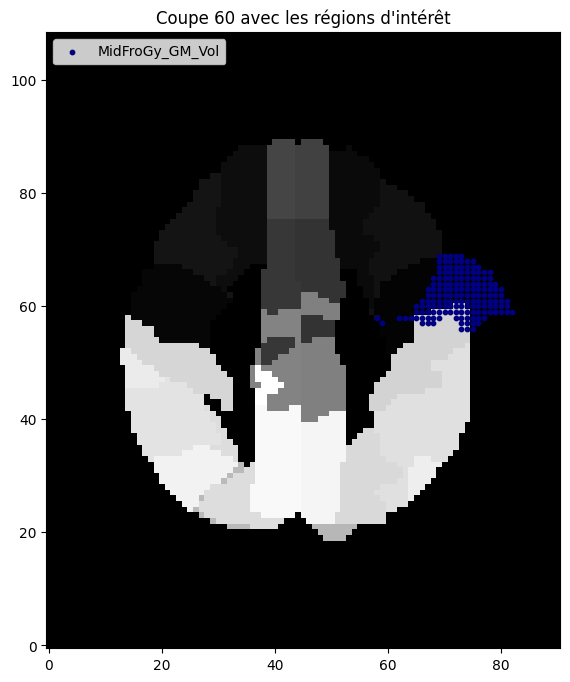

In [80]:

# Exemple de région_table avec les régions à afficher
region_table = {
    'MidFroGy_GM_Vol': 5,

}

# Créer une couleur différente pour chaque région
colors = plt.cm.jet(np.linspace(0, 1, len(region_table)))

# Choisir une coupe spécifique (exemple: coupe 60 sur l'axe z)
slice_idx = 60
slice_data = data[:, :, slice_idx]

# Visualiser la coupe
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(slice_data.T, cmap='gray', origin='lower')
ax.set_title(f"Coupe {slice_idx} avec les régions d'intérêt")

# Superposer les régions d'intérêt sur l'image
for i, (region_name, region_id) in enumerate(region_table.items()):
    # Supprimer l'activation de la région correspondante dans l'image
    region_coords = np.where(slice_data == region_id)
    
    # Afficher la région (surimpression avec une couleur)
    ax.scatter(region_coords[1], region_coords[0], c=[colors[i]], s=10, label=region_name)

# Ajouter une légende
ax.legend(loc='upper left', fontsize=10)

plt.show()


## Comparaison

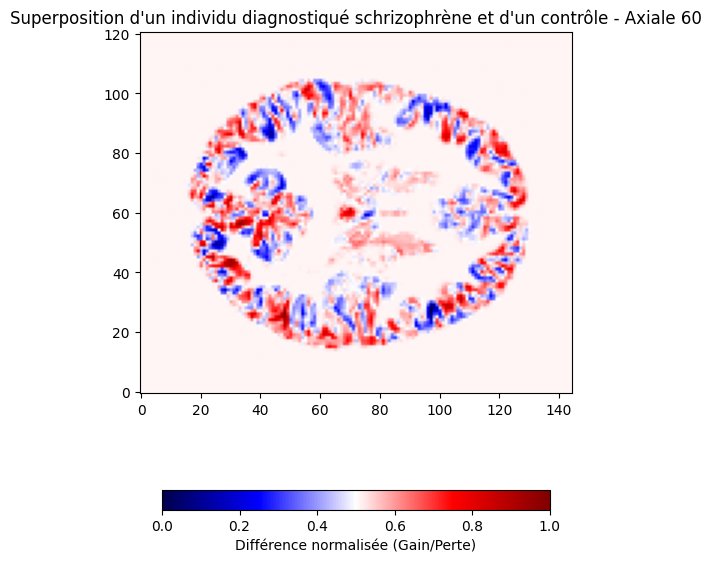

In [21]:
# Sélectionner deux participants
participant_schizophrene = imgs_arr[102, 0]  # Volume 3D du participant 1 (schizophrène)
participant_control = imgs_arr[101, 0]      # Volume 3D du participant 2 (contrôle)

# Calcul de la différence volumétrique
volume_difference = participant_control - participant_schizophrene

# Normaliser la différence pour qu'elle soit visible
normalized_diff = (volume_difference - np.min(volume_difference)) / (np.max(volume_difference) - np.min(volume_difference))

# Index de coupe
slice_idx = 60

# Extraire les coupes (axiale, coronale, sagittale) pour la superposition
diff_axial = normalized_diff[:, :, slice_idx]
diff_coronal = normalized_diff[:, slice_idx, :]
diff_sagittal = normalized_diff[slice_idx, :, :]

# Appliquer le masque AAL pour les régions touchées
aal_axial = mask_arr[:, :, slice_idx]
aal_coronal = mask_arr[:, slice_idx, :]
aal_sagittal = mask_arr[slice_idx, :, :]

# Tracer les graphiques
fig, axes = plt.subplots(1, 1, figsize=(5, 10))

# Couleurs pour la superposition (bleu = gain, rouge = perte)
cmap = plt.cm.seismic  # Bleu -> Rouge

# Axiale
axes.imshow(diff_axial, cmap=cmap, origin='lower')
axes.set_title(f"Superposition d'un individu diagnostiqué schrizophrène et d'un contrôle - Axiale {slice_idx}")

# # Coronale
# axes[1].imshow(diff_coronal, cmap=cmap, origin='lower')
# axes[1].set_title(f"Superposition - Coronale {slice_idx}")

# # Sagittale
# axes[2].imshow(diff_sagittal, cmap=cmap, origin='lower')
# axes[2].set_title(f"Superposition - Sagittale {slice_idx}")

plt.tight_layout()
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label="Différence normalisée (Gain/Perte)")

plt.show()


Le but est de trouver l'atrophie.